In [2]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
rice_cammeo_and_osmancik = fetch_ucirepo(id=545) 
  
# data (as pandas dataframes) 
X = rice_cammeo_and_osmancik.data.features 
y = rice_cammeo_and_osmancik.data.targets 
  
# metadata 
print(rice_cammeo_and_osmancik.metadata) 
  
# variable information 
print(rice_cammeo_and_osmancik.variables) 


{'uci_id': 545, 'name': 'Rice (Cammeo and Osmancik)', 'repository_url': 'https://archive.ics.uci.edu/dataset/545/rice+cammeo+and+osmancik', 'data_url': 'https://archive.ics.uci.edu/static/public/545/data.csv', 'abstract': "A total of 3810 rice grain's images were taken for the two species, processed and feature inferences were made. 7 morphological features were obtained for each grain of rice.", 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 3810, 'num_features': 7, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2019, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5MW4Z', 'creators': [], 'intro_paper': {'title': 'Classification of Rice Varieties Using Artificial Intelligence Methods', 'authors': 'Ilkay Cinar, M. Koklu', 'published_in': 'International Journal of Intelligent Systems and App

In [5]:
import pandas as pd

# Load the dataset
data_url = 'https://archive.ics.uci.edu/static/public/545/data.csv'
df = pd.read_csv(data_url)

# Initial exploration
print(df.head())  # Print the first few rows to understand feature types and values
print(df.describe())  # Get a statistical summary of the features
print(df['Class'].value_counts())  # Check the balance between classes

# Ensure that the Class column is binary encoded
class_mapping = {'Cammeo': 0, 'Osmancik': 1}
df['Class'] = df['Class'].map(class_mapping)

# Checking for any missing values
print(df.isnull().sum())  # This should return all zeros indicating no missing values



    Area   Perimeter  Major_Axis_Length  Minor_Axis_Length  Eccentricity  \
0  15231  525.578979         229.749878          85.093788      0.928882   
1  14656  494.311005         206.020065          91.730972      0.895405   
2  14634  501.122009         214.106781          87.768288      0.912118   
3  13176  458.342987         193.337387          87.448395      0.891861   
4  14688  507.166992         211.743378          89.312454      0.906691   

   Convex_Area    Extent   Class  
0        15617  0.572896  Cammeo  
1        15072  0.615436  Cammeo  
2        14954  0.693259  Cammeo  
3        13368  0.640669  Cammeo  
4        15262  0.646024  Cammeo  
               Area    Perimeter  Major_Axis_Length  Minor_Axis_Length  \
count   3810.000000  3810.000000        3810.000000        3810.000000   
mean   12667.727559   454.239180         188.776222          86.313750   
std     1732.367706    35.597081          17.448679           5.729817   
min     7551.000000   359.100006     

In [7]:
# Normalize the feature columns
features = df.columns[:-1]  # Exclude the target 'Class' column
for feature in features:
    df[feature] = (df[feature] - df[feature].min()) / (df[feature].max() - df[feature].min())

print(df.head())  # Check the first few rows to ensure normalization


       Area  Perimeter  Major_Axis_Length  Minor_Axis_Length  Eccentricity  \
0  0.675937   0.879232           0.901216           0.532417      0.888011   
1  0.625330   0.714095           0.648087           0.670663      0.691980   
2  0.623394   0.750066           0.734349           0.588124      0.789846   
3  0.495071   0.524136           0.512800           0.581461      0.671227   
4  0.628146   0.781992           0.709138           0.620288      0.758067   

   Convex_Area    Extent  Class  
0     0.693917  0.207577      0  
1     0.646009  0.324564      0  
2     0.635636  0.538576      0  
3     0.496220  0.393954      0  
4     0.662711  0.408680      0  


In [8]:
# Manually split the data into training and validation sets
train_size = int(0.8 * len(df))
df = df.sample(frac=1).reset_index(drop=True)  # Shuffle the dataset

train_df = df[:train_size]
validation_df = df[train_size:]

# Separate the feature vectors and target values for both sets
X_train = train_df[features].values
y_train = train_df['Class'].values

X_validation = validation_df[features].values
y_validation = validation_df['Class'].values

print("Training set size:", X_train.shape)
print("Validation set size:", X_validation.shape)


Training set size: (3048, 7)
Validation set size: (762, 7)


In [9]:
# Define K-fold cross validation parameters
K = 5
fold_size = int(len(df) / K)
folds = []

# Create the folds
for i in range(K):
    start = i * fold_size
    end = start + fold_size if i != K - 1 else len(df)
    folds.append(df[start:end])
# Define a range for the regularization parameter lambda
lambda_values = [0.01, 0.1, 1, 10, 100]


In [11]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logistic_regression(X, y, lambda_val, learning_rate=0.01, max_iter=1000):
    # Initialize weights
    weights = np.zeros(X.shape[1])

    # Gradient descent to optimize weights
    for _ in range(max_iter):
        z = np.dot(X, weights)
        predictions = sigmoid(z)
        # Compute the gradient of the loss function with regularization
        gradient = np.dot(X.T, (predictions - y)) / len(y) + lambda_val * weights / len(y)
        # Update weights
        weights -= learning_rate * gradient

    return weights

def predict_proba(X, weights):
    # Predict probabilities using logistic regression
    z = np.dot(X, weights)
    return sigmoid(z)

def predict(X, weights, threshold=0.5):
    # Convert probabilities to binary predictions
    return (predict_proba(X, weights) >= threshold).astype(int)


In [12]:
def evaluate_performance(predictions, actual):
    # Calculate accuracy
    correct_predictions = np.sum(predictions == actual)
    accuracy = correct_predictions / len(actual)
    return accuracy


In [13]:
def k_fold_cross_validation(df, K, lambda_values):
    # Split data into K folds
    fold_size = int(len(df) / K)
    folds = [df.iloc[i*fold_size:(i+1)*fold_size] if i<K-1 else df.iloc[i*fold_size:] for i in range(K)]

    # Dictionary to store performance for each lambda value
    performance_scores = {lambda_val: [] for lambda_val in lambda_values}

    # Cross-validation
    for lambda_val in lambda_values:
        for i in range(K):
            validation_fold = folds[i]
            train_folds = pd.concat([folds[j] for j in range(K) if j != i])

            # Training and validation data
            X_train = train_folds[features].values
            y_train = train_folds['Class'].values
            X_val = validation_fold[features].values
            y_val = validation_fold['Class'].values

            # Train the model
            weights = logistic_regression(X_train, y_train, lambda_val)

            # Validation
            predictions = predict(X_val, weights)
            performance = evaluate_performance(predictions, y_val)

            performance_scores[lambda_val].append(performance)

    # Average performance for each lambda
    average_performance = {lambda_val: np.mean(scores) for lambda_val, scores in performance_scores.items()}
    best_lambda = max(average_performance, key=average_performance.get)

    return best_lambda, average_performance

# Example usage
lambda_values = [0.01, 0.1, 1, 10, 100]
best_lambda, average_performance = k_fold_cross_validation(df, 5, lambda_values)
print("Best lambda:", best_lambda)
print("Performance for each lambda:", average_performance)


Best lambda: 10
Performance for each lambda: {0.01: 0.8041994750656167, 0.1: 0.8041994750656167, 1: 0.8044619422572179, 10: 0.8049868766404199, 100: 0.7997375328083989}


In [15]:
def sigmoid(z):
    """Return the logistic sigmoid function."""
    return 1 / (1 + np.exp(-z))

def logistic_regression_GD(X, y, learning_rate=0.01, max_iter=1000):
    """Train logistic regression model using gradient descent."""
    weights = np.zeros(X.shape[1])  # Initialize weights to zeros
    for _ in range(max_iter):
        z = np.dot(X, weights)
        predictions = sigmoid(z)
        errors = y - predictions
        gradient = np.dot(X.T, errors) / len(y)
        weights += learning_rate * gradient
    return weights

# Assume X_train, y_train are prepared and are numeric arrays
# Assume 'features' are the column names of the features used


In [16]:
def predict(X, weights, threshold=0.5):
    """Make predictions using logistic regression weights."""
    probabilities = sigmoid(np.dot(X, weights))
    return (probabilities >= threshold).astype(int)

def evaluate_performance(predictions, actual):
    """Evaluate model performance based on accuracy."""
    correct_predictions = np.sum(predictions == actual)
    accuracy = correct_predictions / len(actual)
    return accuracy

# Train the model
weights_gd = logistic_regression_GD(X_train, y_train)

# Making predictions
predictions_train = predict(X_train, weights_gd)
predictions_test = predict(X_validation, weights_gd)  # Using validation set as test set

# Evaluating performance
accuracy_train = evaluate_performance(predictions_train, y_train)
accuracy_test = evaluate_performance(predictions_test, y_validation)  # Using validation as test

# Print results
print("Training Accuracy for Logistic Regression with GD:", accuracy_train)
print("Test Accuracy for Logistic Regression with GD:", accuracy_test)


Training Accuracy for Logistic Regression with GD: 0.7913385826771654
Test Accuracy for Logistic Regression with GD: 0.7716535433070866


In [18]:
def logistic_regression_SGD(X, y, learning_rate=0.01, max_iter=1000):
    """Train logistic regression model using stochastic gradient descent."""
    weights = np.zeros(X.shape[1])  # Initialize weights to zeros
    for _ in range(max_iter):
        for i in range(len(y)):
            xi = X[i, :]
            yi = y[i]
            z = np.dot(xi, weights)
            prediction = sigmoid(z)
            error = yi - prediction
            gradient = xi * error
            weights += learning_rate * gradient
    return weights

# Train the model using SGD
weights_sgd = logistic_regression_SGD(X_train, y_train)


In [19]:
# Making predictions
predictions_train_sgd = predict(X_train, weights_sgd)
predictions_test_sgd = predict(X_validation, weights_sgd)  # Using validation set as test set

# Evaluating performance
accuracy_train_sgd = evaluate_performance(predictions_train_sgd, y_train)
accuracy_test_sgd = evaluate_performance(predictions_test_sgd, y_validation)  # Using validation as test

# Print results
print("Training Accuracy for Logistic Regression with SGD:", accuracy_train_sgd)
print("Test Accuracy for Logistic Regression with SGD:", accuracy_test_sgd)


Training Accuracy for Logistic Regression with SGD: 0.9261811023622047
Test Accuracy for Logistic Regression with SGD: 0.9409448818897638


In [20]:
def logistic_regression_L2_GD(X, y, lambda_val, learning_rate=0.01, max_iter=1000):
    """Train logistic regression model with L2 regularization using gradient descent."""
    weights = np.zeros(X.shape[1])  # Initialize weights to zeros
    for _ in range(max_iter):
        z = np.dot(X, weights)
        predictions = sigmoid(z)
        errors = y - predictions
        # Update weights - include the L2 regularization term
        gradient = np.dot(X.T, errors) / len(y) + lambda_val * weights / len(y)
        weights -= learning_rate * gradient
    return weights

# Choose a lambda value for L2 regularization, typically determined via cross-validation
lambda_val = 0.1  # Example value, adjust based on cross-validation results

# Train the model using GD with L2 regularization
weights_l2_gd = logistic_regression_L2_GD(X_train, y_train, lambda_val)


In [21]:
# Making predictions
predictions_train_l2_gd = predict(X_train, weights_l2_gd)
predictions_test_l2_gd = predict(X_validation, weights_l2_gd)  # Using validation set as test set

# Evaluating performance
accuracy_train_l2_gd = evaluate_performance(predictions_train_l2_gd, y_train)
accuracy_test_l2_gd = evaluate_performance(predictions_test_l2_gd, y_validation)  # Using validation as test

# Print results
print("Training Accuracy for Logistic Regression with L2 Regularization (GD):", accuracy_train_l2_gd)
print("Test Accuracy for Logistic Regression with L2 Regularization (GD):", accuracy_test_l2_gd)


Training Accuracy for Logistic Regression with L2 Regularization (GD): 0.5666010498687664
Test Accuracy for Logistic Regression with L2 Regularization (GD): 0.594488188976378


In [22]:
def logistic_regression_L2_SGD(X, y, lambda_val, learning_rate=0.01, max_iter=1000):
    """Train logistic regression model with L2 regularization using stochastic gradient descent."""
    weights = np.zeros(X.shape[1])  # Initialize weights to zeros
    for _ in range(max_iter):
        for i in range(len(y)):
            xi = X[i, :]
            yi = y[i]
            z = np.dot(xi, weights)
            prediction = sigmoid(z)
            error = yi - prediction
            # Update weights - include the L2 regularization term
            gradient = xi * error + lambda_val * weights
            weights -= learning_rate * gradient
    return weights

# Choose a lambda value for L2 regularization, this should ideally be validated
lambda_val = 0.1  # Example value, adjust based on cross-validation results

# Train the model using SGD with L2 regularization
weights_l2_sgd = logistic_regression_L2_SGD(X_train, y_train, lambda_val)


In [23]:
# Making predictions
predictions_train_l2_sgd = predict(X_train, weights_l2_sgd)
predictions_test_l2_sgd = predict(X_validation, weights_l2_sgd)  # Using validation set as test set

# Evaluating performance
accuracy_train_l2_sgd = evaluate_performance(predictions_train_l2_sgd, y_train)
accuracy_test_l2_sgd = evaluate_performance(predictions_test_l2_sgd, y_validation)  # Using validation as test

# Print results
print("Training Accuracy for Logistic Regression with L2 Regularization (SGD):", accuracy_train_l2_sgd)
print("Test Accuracy for Logistic Regression with L2 Regularization (SGD):", accuracy_test_l2_sgd)


Training Accuracy for Logistic Regression with L2 Regularization (SGD): 0.5666010498687664
Test Accuracy for Logistic Regression with L2 Regularization (SGD): 0.594488188976378


In [24]:
# Results data structure
results = [
    ["Logistic Regression with GD", accuracy_train, accuracy_test],
    ["Logistic Regression with SGD", accuracy_train_sgd, accuracy_test_sgd],
    ["Logistic Regression with L2 Regularization (GD)", accuracy_train_l2_gd, accuracy_test_l2_gd],
    ["Logistic Regression with L2 Regularization (SGD)", accuracy_train_l2_sgd, accuracy_test_l2_sgd]
]

# Print the results as a formatted table
print(f"{'Model Description':<50}{'Training Accuracy':<20}{'Test Accuracy'}")
for model_result in results:
    print(f"{model_result[0]:<50}{model_result[1]:<20}{model_result[2]}")

Model Description                                 Training Accuracy   Test Accuracy
Logistic Regression with GD                       0.7913385826771654  0.7716535433070866
Logistic Regression with SGD                      0.9261811023622047  0.9409448818897638
Logistic Regression with L2 Regularization (GD)   0.5666010498687664  0.594488188976378
Logistic Regression with L2 Regularization (SGD)  0.5666010498687664  0.594488188976378


Training Time for GD: 0.2555098533630371
Training Time for SGD: 14.455245733261108


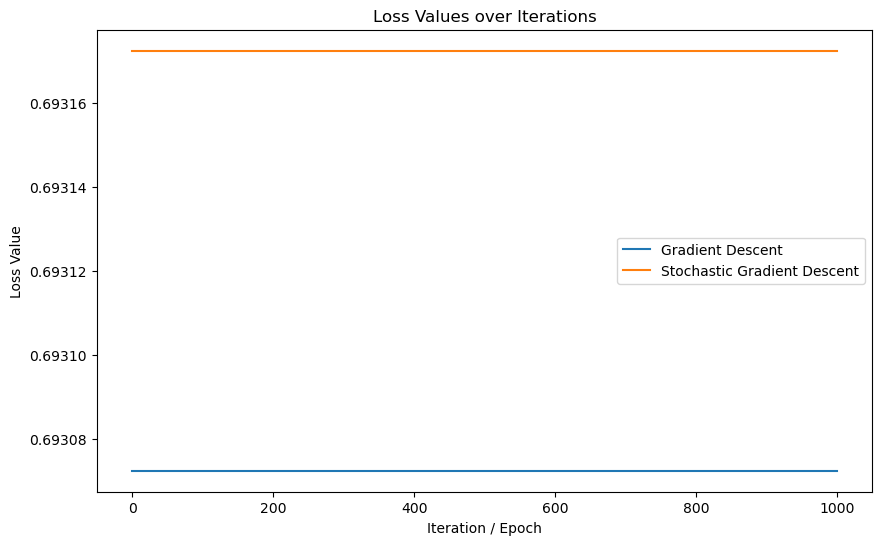

In [30]:
import time

def compute_loss(X, y, weights, lambda_val):
    predictions = sigmoid(np.dot(X, weights))
    # Logistic loss with L2 regularization
    loss = -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions)) + (lambda_val / 2) * np.sum(weights ** 2)
    return loss

def logistic_regression_GD_with_timing(X, y, lambda_val, learning_rate=0.01, max_iter=1000):
    weights = np.zeros(X.shape[1])
    loss_values = []
    start_time = time.time()
    for _ in range(max_iter):
        weights = logistic_regression_GD(X, y, learning_rate, 1)  # GD for 1 iteration
        loss = compute_loss(X, y, weights, lambda_val)
        loss_values.append(loss)
    training_time = time.time() - start_time
    return weights, loss_values, training_time

def logistic_regression_SGD_with_timing(X, y, lambda_val, learning_rate=0.01, max_iter=1000):
    weights = np.zeros(X.shape[1])
    loss_values = []
    start_time = time.time()
    for _ in range(max_iter):
        for i in range(len(y)):
            weights = logistic_regression_SGD(X[i:i+1], y[i:i+1], learning_rate, 1)  # SGD for 1 epoch
        loss = compute_loss(X, y, weights, lambda_val)
        loss_values.append(loss)
    training_time = time.time() - start_time
    return weights, loss_values, training_time
# Define a lambda value for L2 regularization
lambda_val = 0.1

# Train models and record loss and training time
weights_gd, loss_values_gd, training_time_gd = logistic_regression_GD_with_timing(X_train, y_train, lambda_val)
weights_sgd, loss_values_sgd, training_time_sgd = logistic_regression_SGD_with_timing(X_train, y_train, lambda_val)

print("Training Time for GD:", training_time_gd)
print("Training Time for SGD:", training_time_sgd)
import matplotlib.pyplot as plt

# Plot the loss values
plt.figure(figsize=(10, 6))
plt.plot(loss_values_gd, label='Gradient Descent')
plt.plot(loss_values_sgd, label='Stochastic Gradient Descent')
plt.title('Loss Values over Iterations')
plt.xlabel('Iteration / Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()


In [34]:
def logistic_regression_SGD_with_timing(X, y, lambda_val, learning_rate=0.01, max_iter=1000):
    weights = np.zeros(X.shape[1])
    loss_values = []
    start_time = time.time()
    for epoch in range(max_iter):
        for i in np.random.permutation(len(y)):
            xi = X[i:i+1].reshape(-1)  # Make sure xi is a flat array
            yi = np.array([y[i]])  # yi should be a single-element array
            prediction = sigmoid(np.dot(xi, weights))
            error = yi - prediction
            gradient = xi * error + lambda_val * weights
            weights -= learning_rate * gradient.reshape(weights.shape)  # Ensure gradient is shaped correctly
        loss_values.append(compute_loss(X, y, weights, lambda_val))
        learning_rate = lr_schedule(epoch, learning_rate)  # Update learning rate
    training_time = time.time() - start_time
    return weights, loss_values, training_time


In [35]:
def decay_lr_schedule(epoch, current_lr, decay_rate=0.95):
    """Decay the learning rate after each epoch."""
    return current_lr * decay_rate

def oscillating_lr_schedule(epoch, current_lr, base_lr, max_lr, step_size=10):
    """Oscillate the learning rate within a range."""
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    return base_lr + (max_lr - base_lr) * np.maximum(0, (1 - x))
